In [1]:
#python3 -m notebook
import os 
os.environ['CUDA_VISIBLE_DEVICES']='1'
%pylab inline
from tqdm import tqdm


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Fitting kernel at 64**3 particles resolution

In [2]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [3]:
#export PYTHONPATH="$PYTHONPATH//home/george/CAMELS/library/build/lib"
# import sys
# sys.path.append('home/george/CAMELS/library/build/lib')
#import camels_library as cl
import readgadget
import numpy as np

init_cond = 'CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [4]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [01:37<00:00,  2.85s/it]


In [5]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)

In [6]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

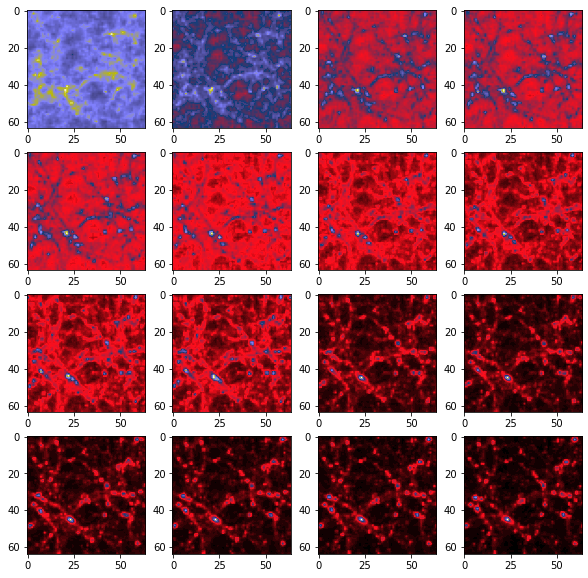

In [7]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

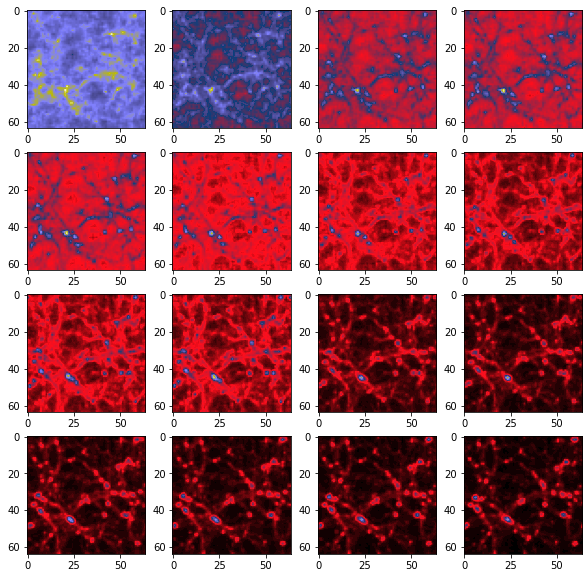

In [8]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [9]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

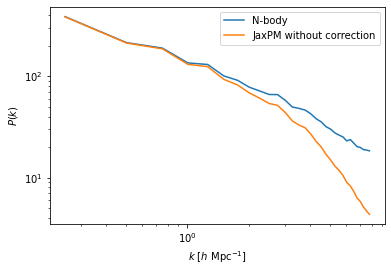

In [10]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [17]:
# Instantiate the neural network
# model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter()(x,a)))

# params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [18]:
from  Net3d import*




# Instantiate the neural network

model = hk.without_apply_rng(hk.transform(lambda x : SpectralConv3()(x)))

params = model.init(next(rng_seq),jnp.zeros([1,1,64,64,33]))

Spectral Initialized


In [19]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    pot_k=pot_k.reshape(1,1,64,64,33)
    pot_k = pot_k + model.apply(params, pot_k)
    pot_k=pot_k.reshape(64,64,33)
    #print(model.apply(params, kk, jnp.atleast_1d(a)))
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [20]:
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)

@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)
  # Optional lines to include velocity in the loss
  vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
  wv = jnp.where(distance < 100, vel, 0.)
  return 0.01*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [21]:
losses = []

In [34]:
import optax
lr_fun= optax.cosine_decay_schedule(0.0005, 1000 , alpha=0.0) #0.1 for 400steps, 0.01
#learning_rate=0.001
optimizer = optax.adam(lr_fun)
opt_state = optimizer.init(params)

In [35]:
for step in tqdm(range(10000)):
  l, params, opt_state = update(params, opt_state)
  if(step%10==0):
    print("Step: ", step, " Loss: ",l)
  losses.append(l)

  0%|          | 1/10000 [00:03<9:36:52,  3.46s/it]

Step:  0  Loss:  0.295977


  0%|          | 11/10000 [00:37<9:34:50,  3.45s/it]

Step:  10  Loss:  0.33327714


  0%|          | 21/10000 [01:12<9:36:07,  3.46s/it]

Step:  20  Loss:  0.30589202


  0%|          | 31/10000 [01:47<9:38:57,  3.48s/it]

Step:  30  Loss:  0.300229


  0%|          | 41/10000 [02:22<9:37:24,  3.48s/it]

Step:  40  Loss:  0.29790854


  1%|          | 51/10000 [02:56<9:37:00,  3.48s/it]

Step:  50  Loss:  0.2967406


  1%|          | 61/10000 [03:31<9:37:54,  3.49s/it]

Step:  60  Loss:  0.29623038


  1%|          | 71/10000 [04:06<9:36:02,  3.48s/it]

Step:  70  Loss:  0.29593974


  1%|          | 81/10000 [04:41<9:36:31,  3.49s/it]

Step:  80  Loss:  0.29577416


  1%|          | 91/10000 [05:16<9:36:24,  3.49s/it]

Step:  90  Loss:  0.29566383


  1%|          | 101/10000 [05:51<9:36:01,  3.49s/it]

Step:  100  Loss:  0.2956217


  1%|          | 111/10000 [06:26<9:35:46,  3.49s/it]

Step:  110  Loss:  0.29551682


  1%|          | 121/10000 [07:01<9:35:04,  3.49s/it]

Step:  120  Loss:  0.29542786


  1%|▏         | 131/10000 [07:36<9:34:24,  3.49s/it]

Step:  130  Loss:  0.29538628


  1%|▏         | 141/10000 [08:10<9:33:49,  3.49s/it]

Step:  140  Loss:  0.29542425


  2%|▏         | 151/10000 [08:45<9:33:18,  3.49s/it]

Step:  150  Loss:  0.2952696


  2%|▏         | 161/10000 [09:20<9:32:39,  3.49s/it]

Step:  160  Loss:  0.2952


  2%|▏         | 171/10000 [09:55<9:32:02,  3.49s/it]

Step:  170  Loss:  0.29520553


  2%|▏         | 181/10000 [10:30<9:31:26,  3.49s/it]

Step:  180  Loss:  0.29513925


  2%|▏         | 191/10000 [11:05<9:30:55,  3.49s/it]

Step:  190  Loss:  0.2950999


  2%|▏         | 201/10000 [11:40<9:30:21,  3.49s/it]

Step:  200  Loss:  0.29505402


  2%|▏         | 211/10000 [12:15<9:29:46,  3.49s/it]

Step:  210  Loss:  0.29499632


  2%|▏         | 221/10000 [12:50<9:29:17,  3.49s/it]

Step:  220  Loss:  0.29489285


  2%|▏         | 231/10000 [13:25<9:28:35,  3.49s/it]

Step:  230  Loss:  0.29480577


  2%|▏         | 241/10000 [14:00<9:28:11,  3.49s/it]

Step:  240  Loss:  0.2948225


  3%|▎         | 251/10000 [14:35<9:27:25,  3.49s/it]

Step:  250  Loss:  0.29496342


  3%|▎         | 261/10000 [15:10<9:26:57,  3.49s/it]

Step:  260  Loss:  0.29472786


  3%|▎         | 271/10000 [15:44<9:26:19,  3.49s/it]

Step:  270  Loss:  0.2946124


  3%|▎         | 281/10000 [16:19<9:25:48,  3.49s/it]

Step:  280  Loss:  0.29471895


  3%|▎         | 291/10000 [16:54<9:25:12,  3.49s/it]

Step:  290  Loss:  0.2946207


  3%|▎         | 301/10000 [17:29<9:24:32,  3.49s/it]

Step:  300  Loss:  0.2945372


  3%|▎         | 311/10000 [18:04<9:23:53,  3.49s/it]

Step:  310  Loss:  0.2944455


  3%|▎         | 321/10000 [18:39<9:23:21,  3.49s/it]

Step:  320  Loss:  0.29444072


  3%|▎         | 331/10000 [19:14<9:22:52,  3.49s/it]

Step:  330  Loss:  0.29441088


  3%|▎         | 341/10000 [19:49<9:22:13,  3.49s/it]

Step:  340  Loss:  0.29430255


  4%|▎         | 351/10000 [20:24<9:21:37,  3.49s/it]

Step:  350  Loss:  0.29431394


  4%|▎         | 361/10000 [20:59<9:21:02,  3.49s/it]

Step:  360  Loss:  0.2942713


  4%|▎         | 371/10000 [21:34<9:20:32,  3.49s/it]

Step:  370  Loss:  0.29423514


  4%|▍         | 381/10000 [22:09<9:19:51,  3.49s/it]

Step:  380  Loss:  0.29426935


  4%|▍         | 391/10000 [22:44<9:19:18,  3.49s/it]

Step:  390  Loss:  0.29420677


  4%|▍         | 401/10000 [23:18<9:18:42,  3.49s/it]

Step:  400  Loss:  0.29410905


  4%|▍         | 411/10000 [23:53<9:18:11,  3.49s/it]

Step:  410  Loss:  0.29404718


  4%|▍         | 421/10000 [24:28<9:17:34,  3.49s/it]

Step:  420  Loss:  0.29407376


  4%|▍         | 431/10000 [25:03<9:17:06,  3.49s/it]

Step:  430  Loss:  0.29408166


  4%|▍         | 441/10000 [25:38<9:16:31,  3.49s/it]

Step:  440  Loss:  0.2940077


  5%|▍         | 451/10000 [26:13<9:15:49,  3.49s/it]

Step:  450  Loss:  0.29395932


  5%|▍         | 461/10000 [26:48<9:14:55,  3.49s/it]

Step:  460  Loss:  0.29394388


  5%|▍         | 471/10000 [27:23<9:14:39,  3.49s/it]

Step:  470  Loss:  0.29388028


  5%|▍         | 481/10000 [27:58<9:13:49,  3.49s/it]

Step:  480  Loss:  0.29391244


  5%|▍         | 491/10000 [28:33<9:12:10,  3.48s/it]

Step:  490  Loss:  0.2938331


  5%|▌         | 501/10000 [29:08<9:11:55,  3.49s/it]

Step:  500  Loss:  0.2937966


  5%|▌         | 511/10000 [29:42<9:10:27,  3.48s/it]

Step:  510  Loss:  0.29380146


  5%|▌         | 521/10000 [30:17<9:10:02,  3.48s/it]

Step:  520  Loss:  0.2938403


  5%|▌         | 531/10000 [30:52<9:09:56,  3.48s/it]

Step:  530  Loss:  0.29377124


  5%|▌         | 541/10000 [31:27<9:09:14,  3.48s/it]

Step:  540  Loss:  0.29374593


  6%|▌         | 551/10000 [32:02<9:08:08,  3.48s/it]

Step:  550  Loss:  0.29369485


  6%|▌         | 561/10000 [32:36<9:08:42,  3.49s/it]

Step:  560  Loss:  0.29369602


  6%|▌         | 571/10000 [33:11<9:07:48,  3.49s/it]

Step:  570  Loss:  0.29365107


  6%|▌         | 581/10000 [33:46<9:08:13,  3.49s/it]

Step:  580  Loss:  0.2936251


  6%|▌         | 591/10000 [34:21<9:07:09,  3.49s/it]

Step:  590  Loss:  0.2936109


  6%|▌         | 601/10000 [34:56<9:06:25,  3.49s/it]

Step:  600  Loss:  0.2935913


  6%|▌         | 611/10000 [35:31<9:05:05,  3.48s/it]

Step:  610  Loss:  0.29357406


  6%|▌         | 621/10000 [36:06<9:05:27,  3.49s/it]

Step:  620  Loss:  0.2935591


  6%|▋         | 631/10000 [36:41<9:05:07,  3.49s/it]

Step:  630  Loss:  0.29354563


  6%|▋         | 641/10000 [37:15<9:04:07,  3.49s/it]

Step:  640  Loss:  0.29353327


  7%|▋         | 651/10000 [37:50<9:03:28,  3.49s/it]

Step:  650  Loss:  0.29351968


  7%|▋         | 661/10000 [38:25<9:03:17,  3.49s/it]

Step:  660  Loss:  0.29351106


  7%|▋         | 671/10000 [39:00<9:02:24,  3.49s/it]

Step:  670  Loss:  0.29349682


  7%|▋         | 681/10000 [39:35<9:02:04,  3.49s/it]

Step:  680  Loss:  0.29348886


  7%|▋         | 691/10000 [40:10<9:01:48,  3.49s/it]

Step:  690  Loss:  0.293477


  7%|▋         | 701/10000 [40:45<9:01:14,  3.49s/it]

Step:  700  Loss:  0.29346812


  7%|▋         | 711/10000 [41:20<9:00:45,  3.49s/it]

Step:  710  Loss:  0.29346102


  7%|▋         | 721/10000 [41:55<9:00:03,  3.49s/it]

Step:  720  Loss:  0.29345208


  7%|▋         | 731/10000 [42:30<8:59:33,  3.49s/it]

Step:  730  Loss:  0.29344416


  7%|▋         | 741/10000 [43:05<8:58:57,  3.49s/it]

Step:  740  Loss:  0.29343852


  8%|▊         | 751/10000 [43:39<8:58:23,  3.49s/it]

Step:  750  Loss:  0.29343307


  8%|▊         | 761/10000 [44:14<8:57:48,  3.49s/it]

Step:  760  Loss:  0.2934281


  8%|▊         | 771/10000 [44:49<8:57:18,  3.49s/it]

Step:  770  Loss:  0.29342118


  8%|▊         | 781/10000 [45:24<8:56:35,  3.49s/it]

Step:  780  Loss:  0.29341596


  8%|▊         | 791/10000 [45:59<8:55:59,  3.49s/it]

Step:  790  Loss:  0.29340962


  8%|▊         | 801/10000 [46:34<8:55:26,  3.49s/it]

Step:  800  Loss:  0.2934075


  8%|▊         | 811/10000 [47:09<8:54:49,  3.49s/it]

Step:  810  Loss:  0.2934024


  8%|▊         | 821/10000 [47:44<8:54:27,  3.49s/it]

Step:  820  Loss:  0.2933994


  8%|▊         | 831/10000 [48:19<8:53:47,  3.49s/it]

Step:  830  Loss:  0.2933956


  8%|▊         | 841/10000 [48:54<8:53:13,  3.49s/it]

Step:  840  Loss:  0.2933931


  9%|▊         | 851/10000 [49:29<8:52:38,  3.49s/it]

Step:  850  Loss:  0.29338992


  9%|▊         | 861/10000 [50:04<8:52:02,  3.49s/it]

Step:  860  Loss:  0.29338753


  9%|▊         | 871/10000 [50:39<8:51:27,  3.49s/it]

Step:  870  Loss:  0.2933859


  9%|▉         | 881/10000 [51:14<8:50:54,  3.49s/it]

Step:  880  Loss:  0.29338413


  9%|▉         | 891/10000 [51:48<8:50:10,  3.49s/it]

Step:  890  Loss:  0.29338235


  9%|▉         | 901/10000 [52:23<8:49:42,  3.49s/it]

Step:  900  Loss:  0.29338086


  9%|▉         | 911/10000 [52:58<8:49:01,  3.49s/it]

Step:  910  Loss:  0.2933799


  9%|▉         | 921/10000 [53:33<8:48:29,  3.49s/it]

Step:  920  Loss:  0.29337904


  9%|▉         | 931/10000 [54:08<8:47:48,  3.49s/it]

Step:  930  Loss:  0.29337847


  9%|▉         | 941/10000 [54:43<8:47:26,  3.49s/it]

Step:  940  Loss:  0.29337823


 10%|▉         | 951/10000 [55:18<8:46:42,  3.49s/it]

Step:  950  Loss:  0.29337764


 10%|▉         | 961/10000 [55:53<8:46:14,  3.49s/it]

Step:  960  Loss:  0.29337758


 10%|▉         | 971/10000 [56:28<8:45:44,  3.49s/it]

Step:  970  Loss:  0.2933774


 10%|▉         | 981/10000 [57:03<8:44:59,  3.49s/it]

Step:  980  Loss:  0.29337746


 10%|▉         | 991/10000 [57:38<8:44:26,  3.49s/it]

Step:  990  Loss:  0.2933774


 10%|█         | 1001/10000 [58:13<8:43:49,  3.49s/it]

Step:  1000  Loss:  0.29337734


 10%|█         | 1011/10000 [58:48<8:43:15,  3.49s/it]

Step:  1010  Loss:  0.2933774


 10%|█         | 1021/10000 [59:22<8:42:42,  3.49s/it]

Step:  1020  Loss:  0.2933774


 10%|█         | 1031/10000 [59:57<8:42:09,  3.49s/it]

Step:  1030  Loss:  0.29337746


 10%|█         | 1041/10000 [1:00:32<8:41:27,  3.49s/it]

Step:  1040  Loss:  0.29337734


 11%|█         | 1051/10000 [1:01:07<8:40:58,  3.49s/it]

Step:  1050  Loss:  0.29337734


 11%|█         | 1061/10000 [1:01:42<8:40:16,  3.49s/it]

Step:  1060  Loss:  0.2933773


 11%|█         | 1071/10000 [1:02:17<8:39:47,  3.49s/it]

Step:  1070  Loss:  0.29337734


 11%|█         | 1081/10000 [1:02:52<8:39:03,  3.49s/it]

Step:  1080  Loss:  0.29337734


 11%|█         | 1083/10000 [1:03:02<8:39:07,  3.49s/it]


KeyboardInterrupt: 

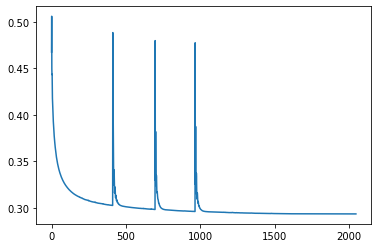

In [41]:
plot(losses)

In [ ]:
kvec = fftk(mesh_shape)
x=numpy.array(kvec)

# Apply a correction filter
kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
kk.shape

/tmp/ipykernel_816507/1093470156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x=numpy.array(kvec)
/tmp/ipykernel_816507/1093470156.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))


(64, 64, 33)

In [ ]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

kvals = jnp.logspace(-2.,0,64*64*33)*sqrt(3)
print(kvals.shape)
#kvalsx=jnp.ones((64,64,33))
kvalsx=kvals.reshape(64,64,33)
mod=model.apply(params, kvalsx)
mod=mod.reshape(64*64*33)

for i, a in enumerate(scales[::2]): 
        semilogx(kvals, mod , color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
plt.colorbar(sm, label='a')

xlim(kvals[0], sqrt(3))
grid()

(135168,)
Spectral Initialized


ValueError: not enough values to unpack (expected 5, got 3)

Initialized


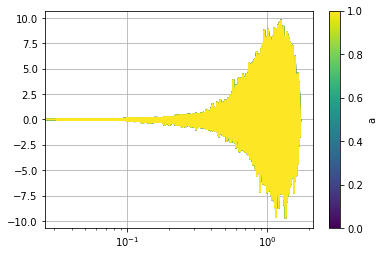

In [ ]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

mod=model.apply(params, kk)
mod=mod.reshape(64*64*33)
kk=kk.reshape(64*64*33)
for i, a in enumerate(scales[::2]): 
        semilogx(kk, mod , color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
plt.colorbar(sm, label='a')

# xlim(kk[0], sqrt(3))
grid()

In [ ]:
resx = np.logspace(-10.,0, 64*64*33)
s = np.meshgrid(resx, 3)
spectrum = np.stack([s[0], s[1], 1-s[0]],axis=-1)

In [ ]:
spectrum.shape

(1, 135168, 3)

In [ ]:
 X = np.array(s)
 X.shape

(2, 1, 135168)

In [28]:
kvec = fftk(mesh_shape)

delta = cic_paint(jnp.zeros(mesh_shape), pos)

delta_k = jnp.fft.rfftn(delta)

# Computes gravitational potential
pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)

# Apply a correction filter
kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
len(kk)

/tmp/ipykernel_147008/872283508.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))


64

In [36]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

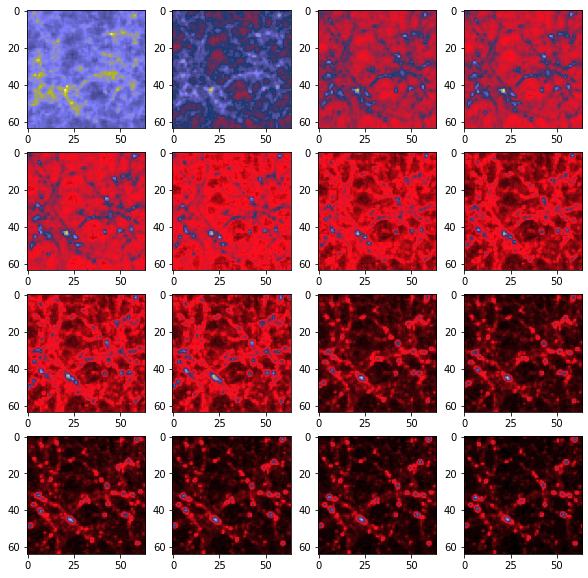

In [37]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [38]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

Text(0, 0.5, '$P(k)$')

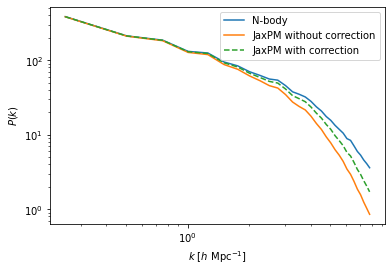

In [39]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [40]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


NameError: name 'col' is not defined

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

NameError: name 'col' is not defined

In [ ]:
import pickle
pickle.dump( params, open( "camels_25_64_pos_vel.params", "wb" ) )